In [69]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 73251308.88it/s]                               


Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
# print(foreground_data.size())
# print(background_data.size())
# torch.save(foreground_data,'foreground_data.pt')
# torch.save(background_data,'background_data.pt')
# torch.save(foreground_label,'foreground_label.pt')
# torch.save(background_label,'background_label.pt')
# torch.load()

In [0]:
# torch.load('foreground_data.pt')
# # print(foreground_data.size())
# # print(background_data.size())

In [0]:

# foreground_data = torch.load('foreground_data.pt')
# background_data = torch.load('background_data.pt')
# foreground_label = torch.load('foreground_label.pt')
# background_label = torch.load('background_label.pt')


In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

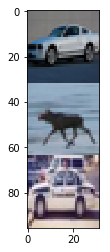

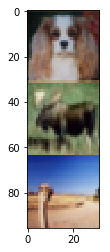

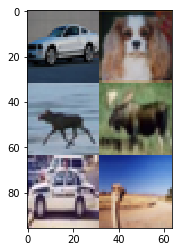

torch.Size([3, 96, 32])


In [7]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



7


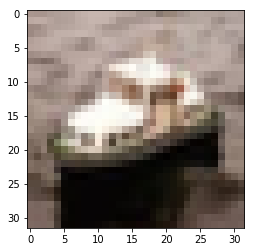

ship


In [10]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      
# net = Module1()
# print(net.parameters)

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)

    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y


In [0]:
fore_net = Module2().double()
# fore_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 100
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    # zero the parameter gradients
    
    optimizer.zero_grad()
    
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if cnt % 40 == 39:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 40))
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 4:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1
      
  if epoch % 5 == 4:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    #************************************************************************
    #testing data set  
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.099
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.098
[3,    40] loss: 1.099
[3,    80] loss: 1.098
[3,   120] loss: 1.098
[4,    40] loss: 1.098
[4,    80] loss: 1.098
[4,   120] loss: 1.098
[5,    40] loss: 1.098
[5,    80] loss: 1.097
[5,   120] loss: 1.097
[6,    40] loss: 1.096
[6,    80] loss: 1.094
[6,   120] loss: 1.094
[7,    40] loss: 1.091
[7,    80] loss: 1.089
[7,   120] loss: 1.085
[8,    40] loss: 1.084
[8,    80] loss: 1.075
[8,   120] loss: 1.078
[9,    40] loss: 1.078
[9,    80] loss: 1.074
[9,   120] loss: 1.070
[10,    40] loss: 1.071
[10,    80] loss: 1.070
[10,   120] loss: 1.070
[11,    40] loss: 1.071
[11,    80] loss: 1.068
[11,   120] loss: 1.066
[12,    40] loss: 1.067
[12,    80] loss: 1.066
[12,   120] loss: 1.066
[13,    40] loss: 1.067
[13,    80] loss: 1.061
[13,   120] loss: 1.063
[14,    40] loss: 1.061
[14,    80] loss: 1.061
[14,   120] loss: 1.060
[15,    40] loss: 1

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]


In [0]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [0]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [102]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        4             0  ...                   1269                   17550
1        9             0  ...                   1855                   15587
2       14             0  ...                   3160                   13668
3       19             0  ...                   4220                   12144
4       24          1219  ...                   3574                   11012
5       29          9536  ...                   2745                    9402
6       34         16501  ...                   2397                    7181
7       39         20689  ...                   1881                    5401
8       44         22674  ...                   1417                    4150
9       49         24162  ...                   1021                    3318
10      54         24861  ...                    771                    2619
11      59         25055  ...                    602                    2322
12      64         25496  ...                    456                    1830
13      69         25905  ...                    376                    1430
14      74         25908  ...                    327                    1368
15      79         25888  ...                    295                    1122
16      84         26213  ...                    193                     847
17      89         26059  ...                    197                     727
18      94         25996  ...                    142                     469
19      99         25847  ...                    159                     514

[20 rows x 7 columns]

In [103]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        4             0  ...                    436                    5900
1        9             0  ...                    661                    5151
2       14             0  ...                   1105                    4525
3       19             0  ...                   1548                    3989
4       24           287  ...                   1189                    3532
5       29          3106  ...                    917                    3132
6       34          5775  ...                    868                    2375
7       39          6313  ...                    723                    1991
8       44          7295  ...                    584                    1811
9       49          7822  ...                    649                    1458
10      54          7666  ...                    493                    1437
11      59          8577  ...                    364                    1391
12      64          8157  ...                    394                    1325
13      69          8448  ...                    356                    1324
14      74          8082  ...                    384                    1254
15      79          8278  ...                    411                    1230
16      84          8498  ...                    330                    1180
17      89          8304  ...                    361                    1200
18      94          8217  ...                    345                    1145
19      99          7999  ...                    423                    1090

[20 rows x 7 columns]

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/CIFAR Mosaic/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/CIFAR Mosaic/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


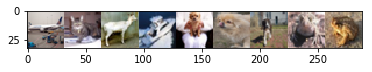

tensor([0.0061, 0.0017, 0.0050, 0.8727, 0.0029, 0.0019, 0.0176, 0.0906, 0.0013],
       dtype=torch.float64)


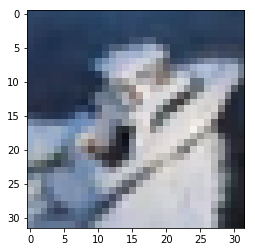

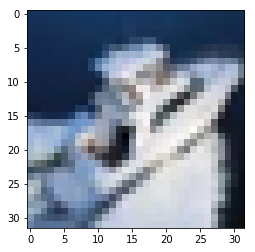

predicted ship
true ship
****************************************************************************************************


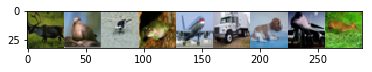

tensor([0.0296, 0.1037, 0.0151, 0.0008, 0.0413, 0.7077, 0.0049, 0.0959, 0.0010],
       dtype=torch.float64)


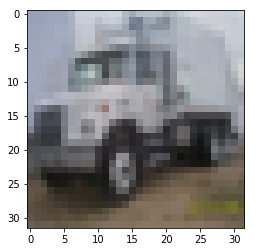

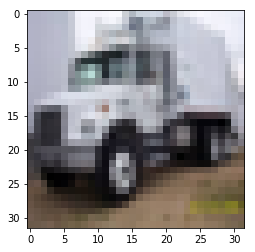

predicted truck
true truck
****************************************************************************************************


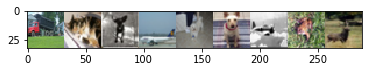

tensor([8.6255e-01, 8.5026e-04, 1.8722e-02, 2.2184e-02, 4.7115e-04, 5.5833e-02,
        2.4305e-02, 5.0166e-03, 1.0072e-02], dtype=torch.float64)


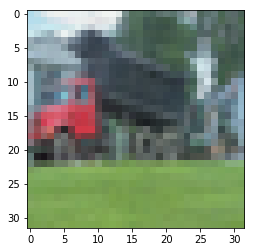

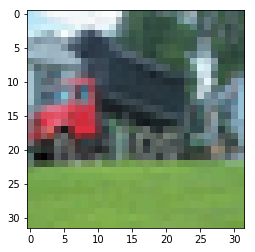

predicted truck
true truck
****************************************************************************************************


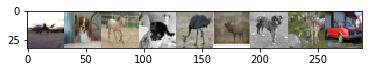

tensor([0.0651, 0.0323, 0.6392, 0.0071, 0.1186, 0.0197, 0.0819, 0.0188, 0.0173],
       dtype=torch.float64)


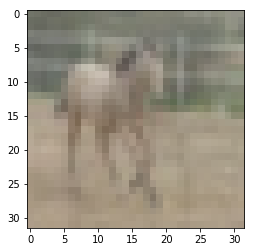

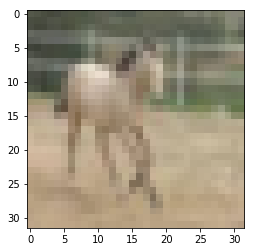

predicted horse
true horse
****************************************************************************************************


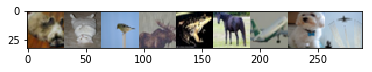

tensor([3.8244e-03, 3.2845e-03, 6.2799e-04, 2.2923e-02, 1.4861e-03, 9.4755e-01,
        1.1359e-03, 5.6861e-03, 1.3485e-02], dtype=torch.float64)


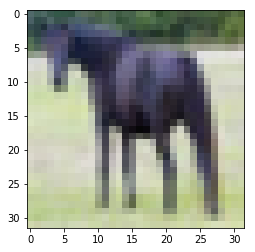

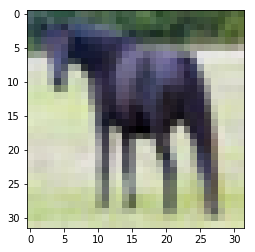

predicted horse
true horse
****************************************************************************************************


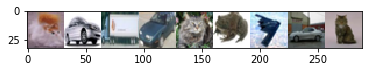

tensor([3.9666e-03, 3.8500e-03, 9.4851e-01, 3.3107e-03, 1.2242e-03, 1.7459e-03,
        1.2075e-04, 2.9579e-02, 7.6908e-03], dtype=torch.float64)


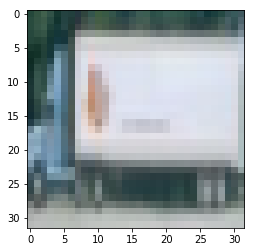

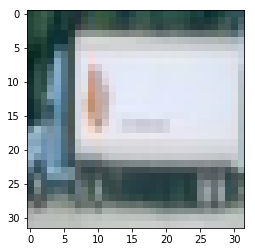

predicted truck
true truck
****************************************************************************************************


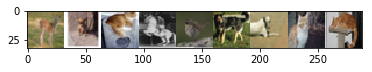

tensor([0.0049, 0.0109, 0.0212, 0.8996, 0.0281, 0.0080, 0.0105, 0.0082, 0.0087],
       dtype=torch.float64)


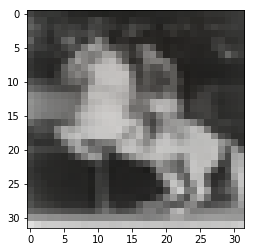

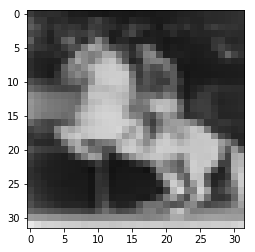

predicted horse
true horse
****************************************************************************************************


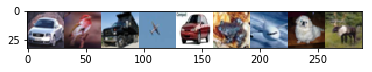

tensor([0.0096, 0.0460, 0.8951, 0.0042, 0.0074, 0.0090, 0.0207, 0.0058, 0.0021],
       dtype=torch.float64)


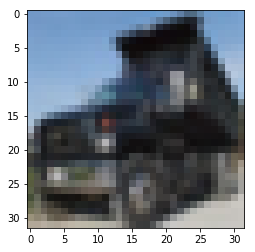

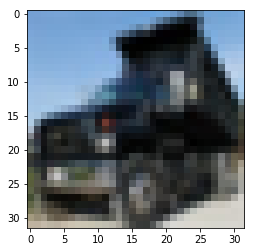

predicted truck
true truck
****************************************************************************************************


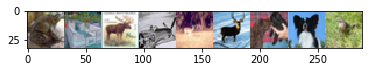

tensor([0.1167, 0.3668, 0.1068, 0.2444, 0.0492, 0.0116, 0.0621, 0.0364, 0.0060],
       dtype=torch.float64)


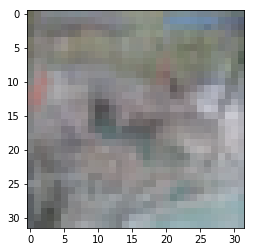

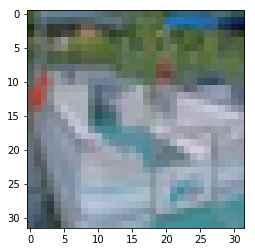

predicted ship
true ship
****************************************************************************************************


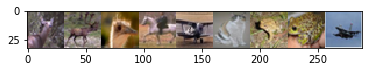

tensor([2.3235e-01, 1.2202e-01, 5.6984e-03, 1.8891e-01, 3.9604e-01, 2.6973e-02,
        1.2287e-04, 2.1894e-02, 5.9893e-03], dtype=torch.float64)


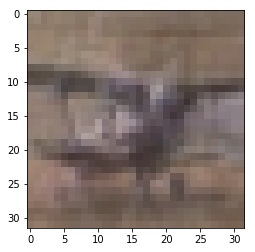

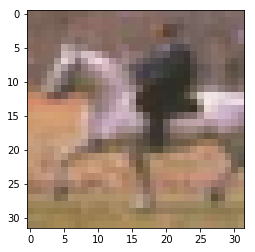

predicted horse
true horse
****************************************************************************************************


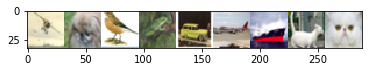

tensor([0.0041, 0.0583, 0.0071, 0.0263, 0.0137, 0.0181, 0.8234, 0.0321, 0.0170],
       dtype=torch.float64)


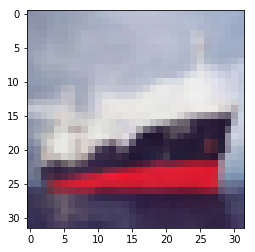

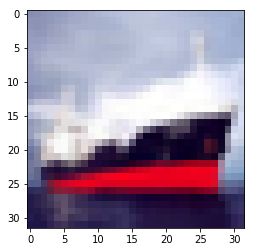

predicted ship
true ship
****************************************************************************************************


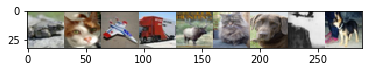

tensor([6.9784e-03, 1.2590e-04, 6.6808e-03, 8.5703e-01, 2.4103e-03, 7.7884e-02,
        1.6341e-02, 2.4170e-02, 8.3760e-03], dtype=torch.float64)


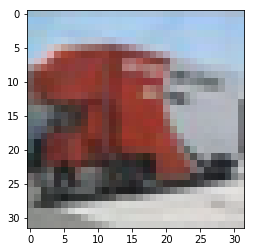

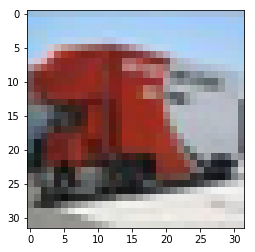

predicted truck
true truck
****************************************************************************************************


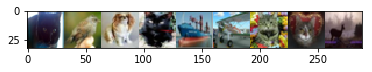

tensor([4.6842e-03, 1.2569e-04, 7.4591e-04, 1.5506e-04, 9.8951e-01, 1.2909e-03,
        1.2216e-03, 9.8025e-05, 2.1658e-03], dtype=torch.float64)


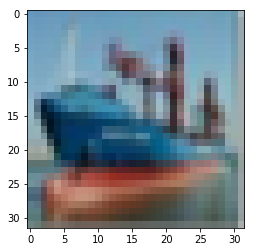

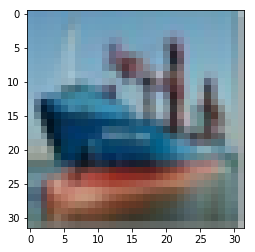

predicted ship
true ship
****************************************************************************************************


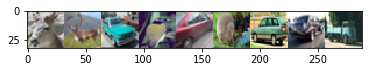

tensor([1.1984e-02, 6.2791e-03, 9.4299e-03, 9.8862e-03, 6.6887e-02, 6.2306e-03,
        7.3473e-04, 4.7818e-02, 8.4075e-01], dtype=torch.float64)


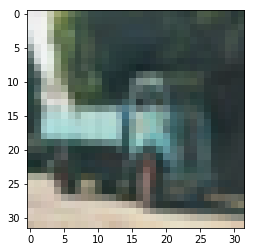

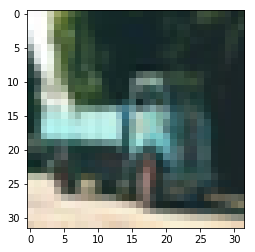

predicted truck
true truck
****************************************************************************************************


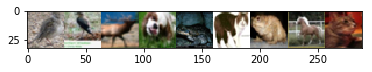

tensor([1.4659e-02, 1.2172e-02, 7.5953e-02, 7.9124e-02, 4.0551e-02, 3.8492e-01,
        1.1916e-05, 3.8965e-01, 2.9534e-03], dtype=torch.float64)


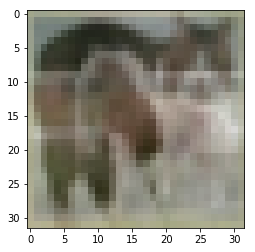

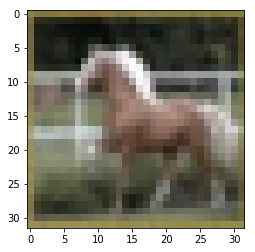

predicted horse
true horse
****************************************************************************************************


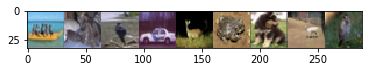

tensor([8.8710e-01, 2.2545e-03, 8.5143e-03, 8.8684e-02, 1.4719e-04, 1.7095e-04,
        3.4079e-03, 2.0039e-03, 7.7175e-03], dtype=torch.float64)


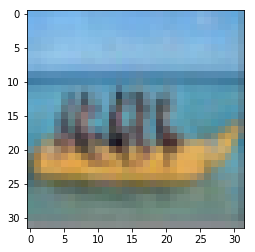

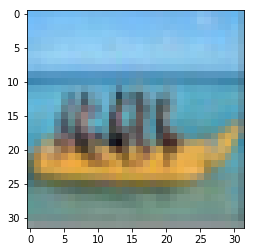

predicted ship
true ship
****************************************************************************************************


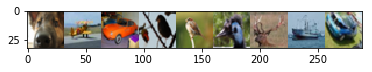

tensor([1.3421e-04, 5.5819e-03, 8.1150e-05, 2.9991e-06, 1.4143e-04, 1.2269e-04,
        2.9100e-04, 9.9359e-01, 4.9736e-05], dtype=torch.float64)


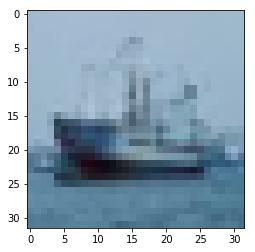

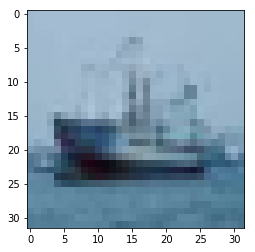

predicted ship
true ship
****************************************************************************************************


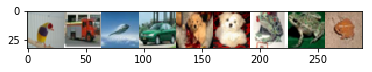

tensor([3.5342e-02, 7.2186e-01, 3.5778e-02, 1.9219e-01, 1.7826e-03, 6.7815e-05,
        2.7542e-03, 6.1411e-03, 4.0850e-03], dtype=torch.float64)


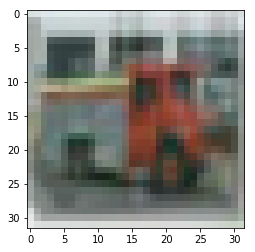

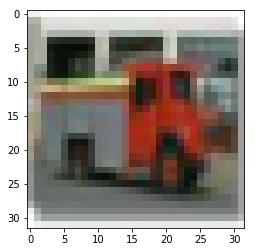

predicted truck
true truck
****************************************************************************************************


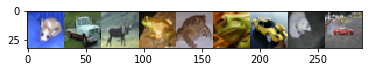

tensor([2.0090e-07, 5.8222e-03, 1.9929e-01, 3.7260e-04, 2.0070e-03, 1.2050e-04,
        5.4357e-03, 7.4832e-01, 3.8627e-02], dtype=torch.float64)


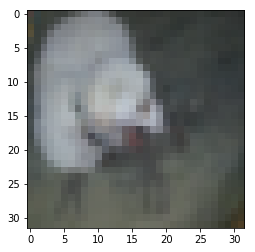

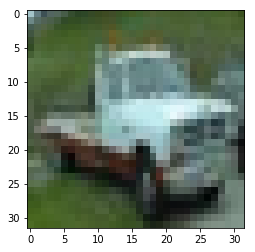

predicted truck
true truck
****************************************************************************************************


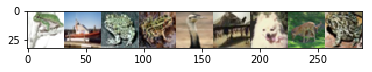

tensor([1.4309e-04, 9.9367e-01, 1.6806e-03, 8.1424e-05, 2.3367e-04, 1.2752e-03,
        5.1669e-05, 2.7404e-03, 1.2274e-04], dtype=torch.float64)


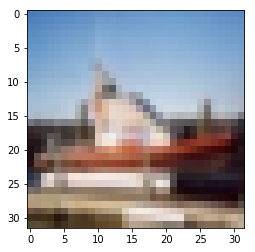

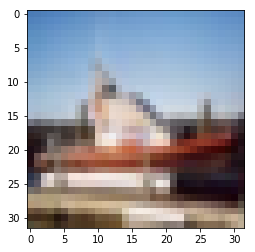

predicted ship
true ship
****************************************************************************************************


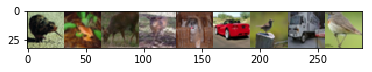

tensor([1.8998e-03, 4.3409e-04, 2.6028e-02, 5.8359e-02, 2.8719e-02, 4.1076e-03,
        1.2010e-02, 8.6671e-01, 1.7298e-03], dtype=torch.float64)


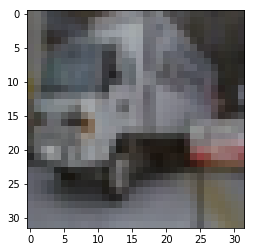

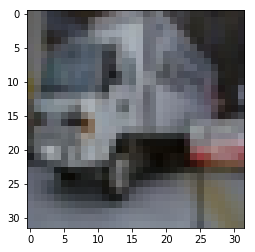

predicted truck
true truck
****************************************************************************************************


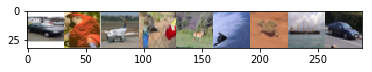

tensor([9.6221e-05, 1.3585e-05, 9.0912e-04, 2.1586e-04, 4.0235e-04, 1.0894e-02,
        2.0291e-04, 9.8675e-01, 5.1932e-04], dtype=torch.float64)


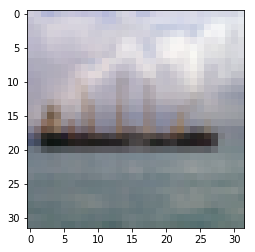

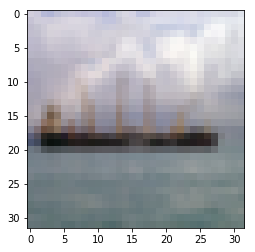

predicted ship
true ship
****************************************************************************************************


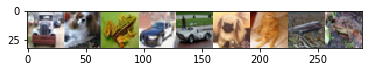

tensor([8.5137e-01, 2.4564e-02, 4.9115e-04, 2.8171e-04, 3.5458e-02, 8.7817e-03,
        2.4484e-03, 4.5528e-02, 3.1077e-02], dtype=torch.float64)


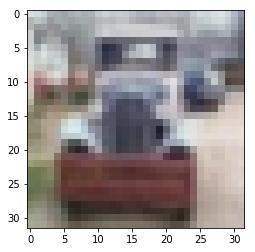

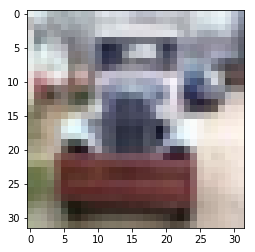

predicted truck
true truck
****************************************************************************************************


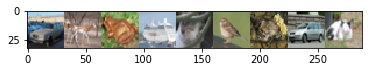

tensor([2.1539e-03, 1.5070e-03, 8.4763e-05, 9.9228e-01, 5.6124e-04, 6.4915e-04,
        1.9757e-03, 2.0857e-04, 5.7900e-04], dtype=torch.float64)


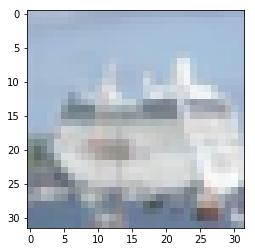

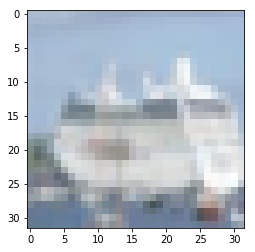

predicted ship
true ship
****************************************************************************************************


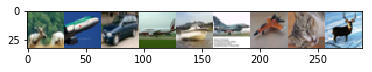

tensor([0.0466, 0.0595, 0.0126, 0.0071, 0.7254, 0.0473, 0.0285, 0.0711, 0.0017],
       dtype=torch.float64)


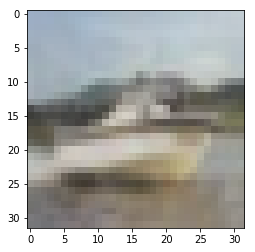

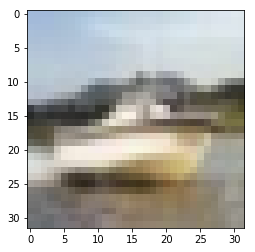

predicted ship
true ship
****************************************************************************************************


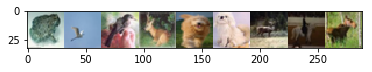

tensor([0.0103, 0.0495, 0.0300, 0.0074, 0.0251, 0.3084, 0.4754, 0.0871, 0.0068],
       dtype=torch.float64)


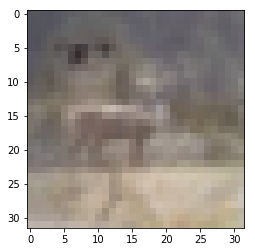

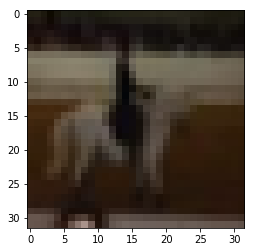

predicted horse
true horse
****************************************************************************************************


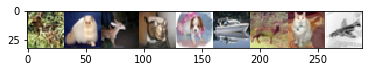

tensor([0.0293, 0.0065, 0.0083, 0.0418, 0.1478, 0.7585, 0.0030, 0.0014, 0.0035],
       dtype=torch.float64)


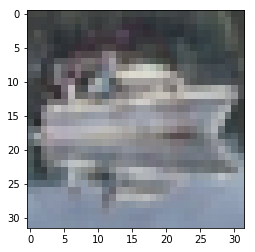

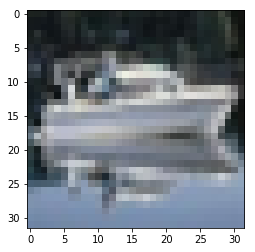

predicted ship
true ship
****************************************************************************************************


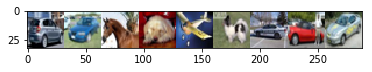

tensor([0.0540, 0.0261, 0.4445, 0.0029, 0.0383, 0.1117, 0.3098, 0.0080, 0.0046],
       dtype=torch.float64)


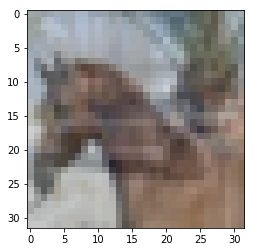

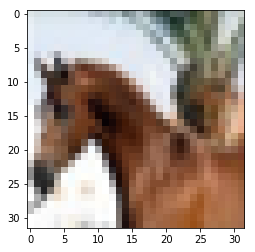

predicted horse
true horse
****************************************************************************************************


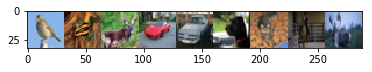

tensor([0.0028, 0.0478, 0.0082, 0.0028, 0.0660, 0.0292, 0.0154, 0.6995, 0.1283],
       dtype=torch.float64)


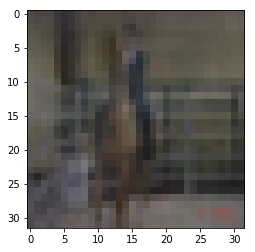

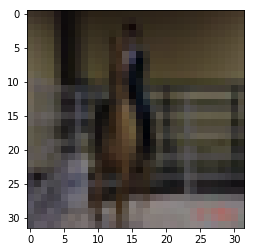

predicted horse
true horse
****************************************************************************************************


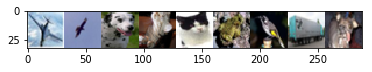

tensor([1.9065e-04, 2.3012e-04, 8.9136e-04, 3.3183e-03, 9.6159e-05, 1.4885e-03,
        2.1637e-05, 9.9288e-01, 8.8423e-04], dtype=torch.float64)


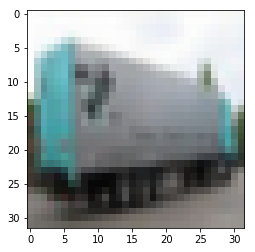

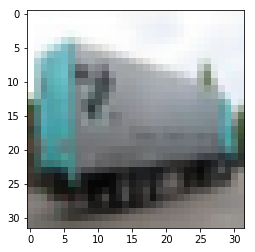

predicted truck
true truck
****************************************************************************************************


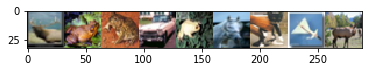

tensor([0.1144, 0.0016, 0.0055, 0.0870, 0.2824, 0.0405, 0.1644, 0.2018, 0.1024],
       dtype=torch.float64)


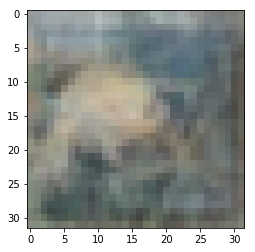

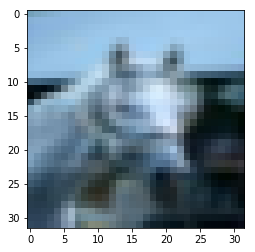

predicted horse
true horse
****************************************************************************************************


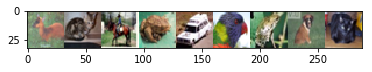

tensor([6.3052e-03, 1.4363e-02, 8.2035e-01, 2.0706e-02, 9.9538e-02, 6.0266e-04,
        8.6274e-04, 1.6956e-02, 2.0320e-02], dtype=torch.float64)


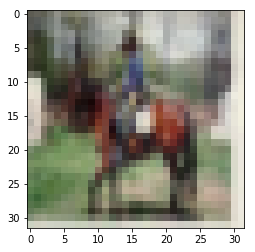

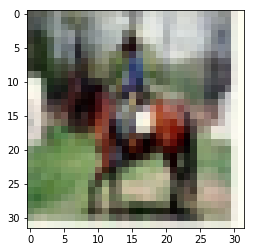

predicted horse
true horse
****************************************************************************************************


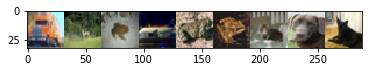

tensor([0.6057, 0.0274, 0.0109, 0.1809, 0.0168, 0.0125, 0.0452, 0.0919, 0.0087],
       dtype=torch.float64)


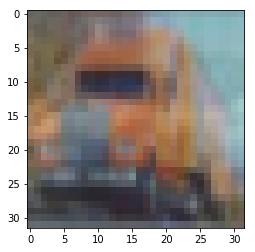

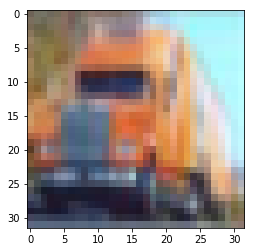

predicted truck
true truck
****************************************************************************************************


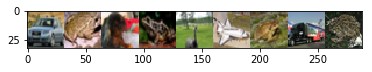

tensor([7.4111e-03, 2.4540e-04, 4.0189e-02, 6.5679e-02, 1.4812e-02, 5.4563e-02,
        2.0870e-03, 8.0816e-01, 6.8570e-03], dtype=torch.float64)


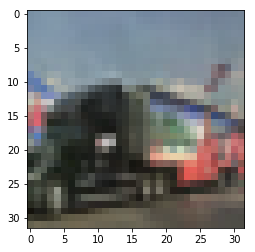

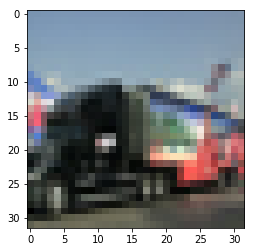

predicted truck
true truck
****************************************************************************************************


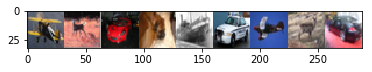

tensor([5.2723e-03, 3.5824e-02, 3.6959e-03, 2.7439e-03, 8.7925e-01, 4.6202e-03,
        2.5621e-04, 4.1572e-02, 2.6765e-02], dtype=torch.float64)


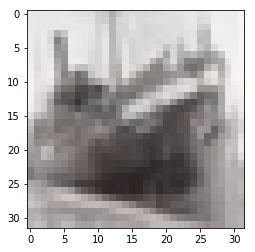

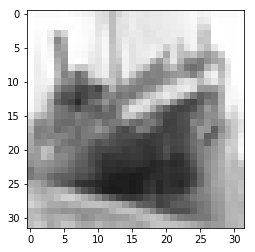

predicted ship
true ship
****************************************************************************************************


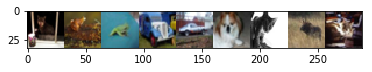

tensor([0.0064, 0.0091, 0.0061, 0.9496, 0.0041, 0.0043, 0.0054, 0.0055, 0.0094],
       dtype=torch.float64)


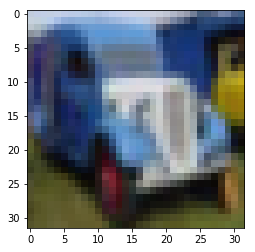

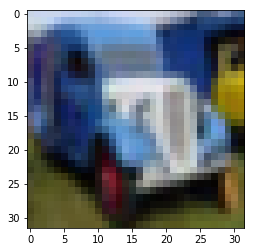

predicted truck
true truck
****************************************************************************************************


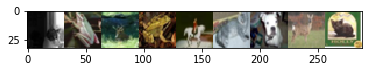

tensor([0.2795, 0.0006, 0.0350, 0.0010, 0.5170, 0.0036, 0.0522, 0.0553, 0.0558],
       dtype=torch.float64)


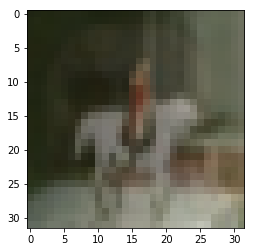

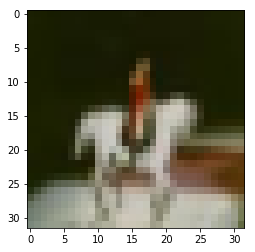

predicted horse
true horse
****************************************************************************************************


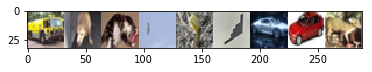

tensor([0.6921, 0.0305, 0.0139, 0.0602, 0.0602, 0.0073, 0.0550, 0.0435, 0.0373],
       dtype=torch.float64)


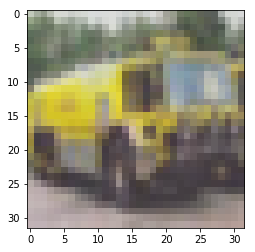

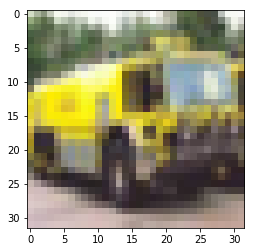

predicted truck
true truck
****************************************************************************************************


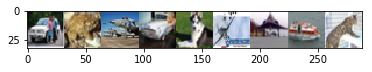

tensor([2.2663e-03, 7.4913e-03, 7.0842e-02, 9.7392e-03, 8.0618e-05, 6.9637e-02,
        5.7166e-02, 7.7712e-01, 5.6591e-03], dtype=torch.float64)


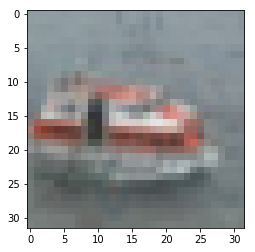

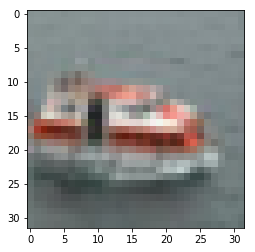

predicted ship
true ship
****************************************************************************************************


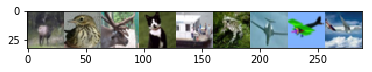

tensor([6.3966e-04, 7.0428e-04, 5.7869e-04, 1.8185e-03, 9.9355e-01, 2.9093e-04,
        1.2526e-04, 6.4479e-08, 2.2956e-03], dtype=torch.float64)


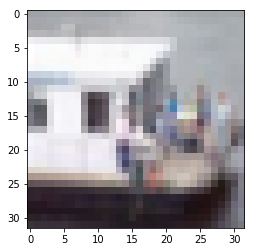

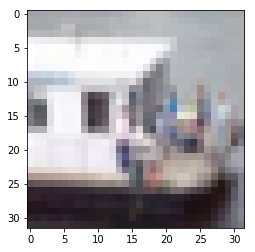

predicted ship
true ship
****************************************************************************************************


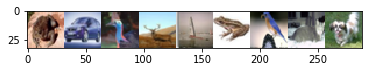

tensor([0.0040, 0.0036, 0.0090, 0.1951, 0.6599, 0.0035, 0.0012, 0.0063, 0.1172],
       dtype=torch.float64)


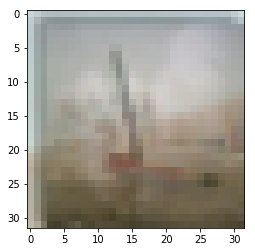

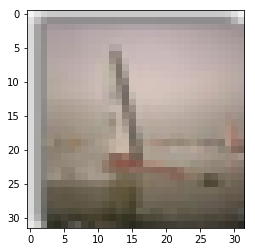

predicted ship
true ship
****************************************************************************************************


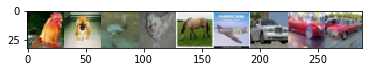

tensor([6.9510e-05, 9.9855e-04, 3.1629e-02, 1.9923e-02, 7.0004e-01, 1.9299e-02,
        2.3282e-02, 1.9931e-01, 5.4551e-03], dtype=torch.float64)


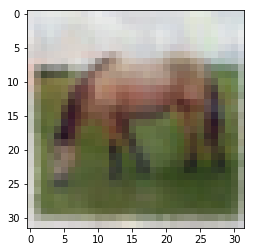

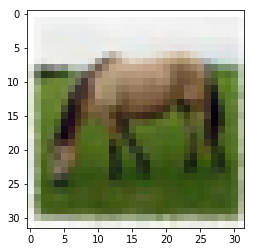

predicted horse
true horse
****************************************************************************************************


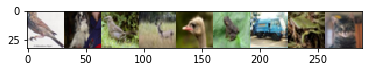

tensor([2.0887e-03, 4.6458e-04, 5.2586e-03, 8.1611e-02, 1.1484e-02, 3.0899e-03,
        8.2855e-01, 3.0399e-02, 3.7056e-02], dtype=torch.float64)


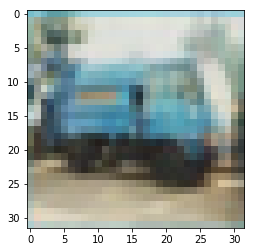

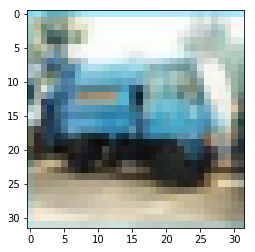

predicted truck
true truck
****************************************************************************************************


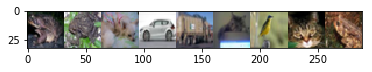

tensor([1.0399e-03, 5.1694e-03, 3.3736e-02, 1.9245e-03, 9.5536e-01, 3.0220e-04,
        2.2832e-04, 1.9180e-03, 3.1697e-04], dtype=torch.float64)


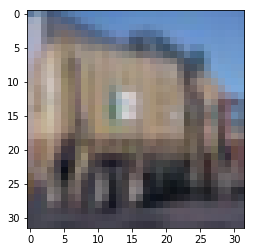

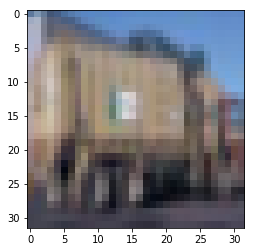

predicted truck
true truck
****************************************************************************************************


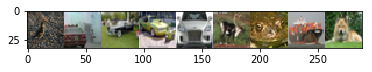

tensor([6.8108e-03, 5.5821e-01, 4.9822e-03, 9.3390e-03, 2.3436e-02, 1.5970e-03,
        7.4138e-04, 3.9462e-01, 2.6370e-04], dtype=torch.float64)


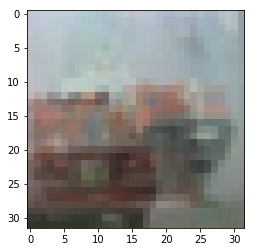

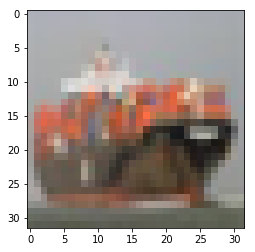

predicted ship
true ship
****************************************************************************************************


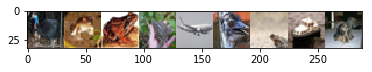

tensor([0.0024, 0.0053, 0.0044, 0.0038, 0.0064, 0.0257, 0.0033, 0.9472, 0.0018],
       dtype=torch.float64)


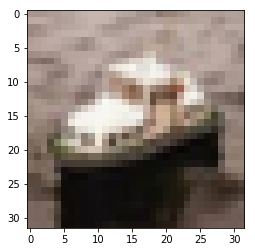

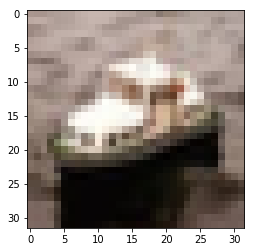

predicted ship
true ship
****************************************************************************************************


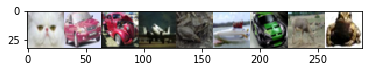

tensor([0.0219, 0.1141, 0.0577, 0.0554, 0.0764, 0.5115, 0.0511, 0.0976, 0.0142],
       dtype=torch.float64)


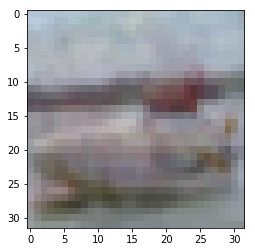

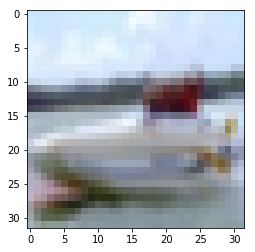

predicted ship
true ship
****************************************************************************************************


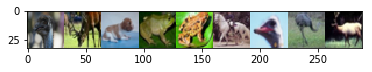

tensor([1.6706e-03, 3.9802e-03, 6.9692e-04, 3.4315e-05, 3.8624e-05, 9.5306e-01,
        1.7486e-03, 3.7089e-02, 1.6778e-03], dtype=torch.float64)


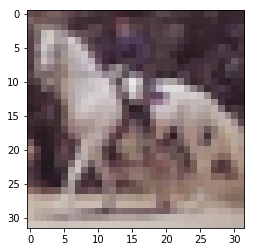

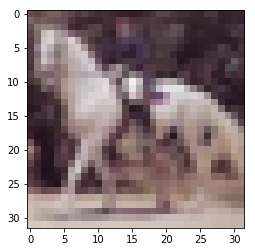

predicted horse
true horse
****************************************************************************************************


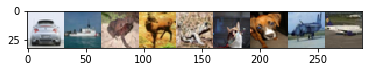

tensor([9.9937e-03, 9.7607e-01, 3.5438e-04, 9.0659e-05, 1.0109e-05, 3.6150e-03,
        7.3733e-05, 3.2297e-03, 6.5582e-03], dtype=torch.float64)


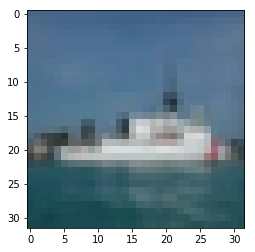

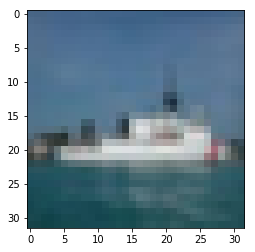

predicted ship
true ship
****************************************************************************************************


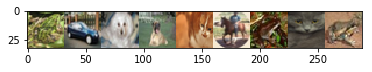

tensor([0.0057, 0.2153, 0.0245, 0.0151, 0.0095, 0.6832, 0.0033, 0.0427, 0.0008],
       dtype=torch.float64)


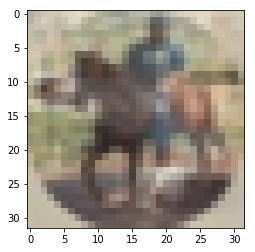

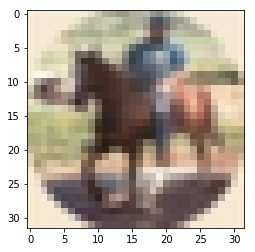

predicted horse
true horse
Accuracy of the network on the 30000 train images: 98 %
total correct 29469
total train set images 30000
focus_true_pred_true 45
focus_false_pred_true 5
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 44
argmax_less_than_half 6


In [106]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1)

        print(alphas[j])

        img2 = avg_images[j]
        display(img2)

        img3 = inputs[j][fore_idx[j]]
        display(img3)

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

3


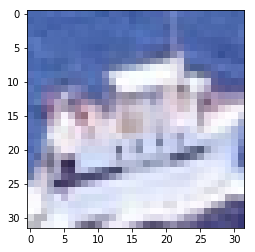

ship


In [110]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


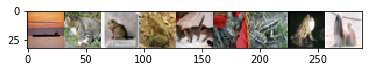

tensor([0.1489, 0.2253, 0.0242, 0.0116, 0.0128, 0.0085, 0.0043, 0.0994, 0.4649],
       dtype=torch.float64)


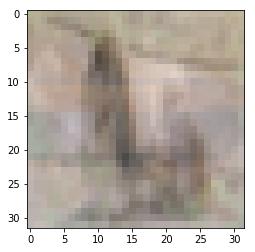

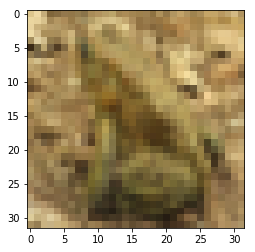

predicted horse
true ship
****************************************************************************************************


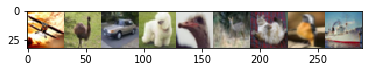

tensor([8.6522e-06, 2.9475e-04, 4.0134e-03, 5.4484e-03, 2.4828e-02, 1.0064e-02,
        1.4906e-02, 4.8587e-03, 9.3558e-01], dtype=torch.float64)


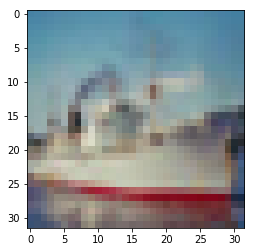

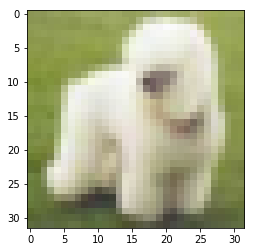

predicted ship
true ship
****************************************************************************************************


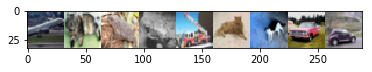

tensor([0.0418, 0.0159, 0.0245, 0.0573, 0.8354, 0.0089, 0.0093, 0.0033, 0.0035],
       dtype=torch.float64)


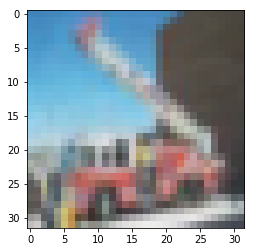

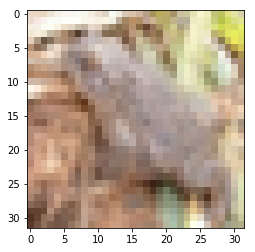

predicted truck
true truck
****************************************************************************************************


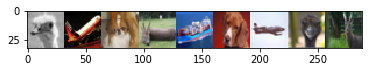

tensor([1.6490e-03, 7.3474e-04, 3.4862e-03, 7.9878e-02, 8.7652e-01, 3.0176e-03,
        5.0096e-03, 8.5209e-04, 2.8856e-02], dtype=torch.float64)


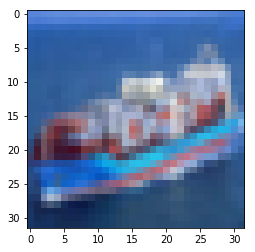

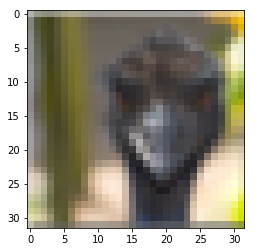

predicted ship
true ship
****************************************************************************************************


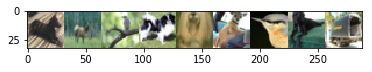

tensor([1.2568e-02, 1.7417e-02, 1.9901e-02, 7.7285e-03, 4.4205e-03, 3.4846e-01,
        2.4149e-05, 5.4232e-01, 4.7159e-02], dtype=torch.float64)


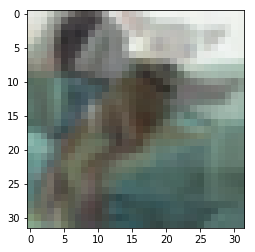

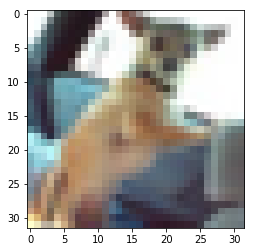

predicted horse
true truck
****************************************************************************************************


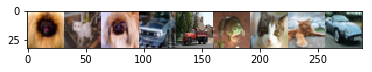

tensor([7.8866e-04, 5.1054e-04, 5.2681e-03, 2.4320e-03, 9.8300e-01, 1.4079e-04,
        6.6854e-04, 6.0380e-03, 1.1579e-03], dtype=torch.float64)


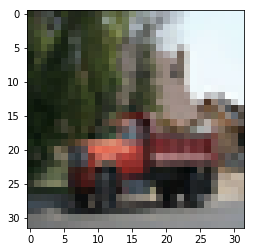

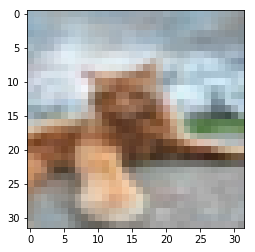

predicted truck
true truck
****************************************************************************************************


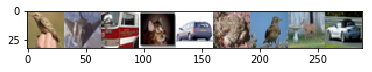

tensor([0.0303, 0.3012, 0.4929, 0.0319, 0.0089, 0.0258, 0.0119, 0.0748, 0.0223],
       dtype=torch.float64)


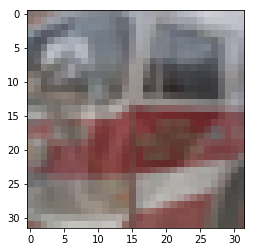

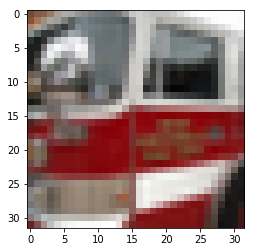

predicted truck
true truck
****************************************************************************************************


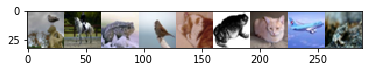

tensor([0.0180, 0.5894, 0.0040, 0.0014, 0.0016, 0.0090, 0.1415, 0.0028, 0.2324],
       dtype=torch.float64)


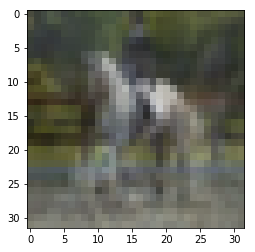

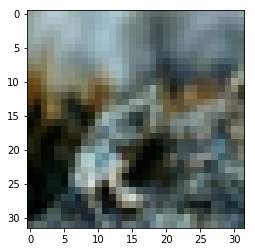

predicted horse
true horse
****************************************************************************************************


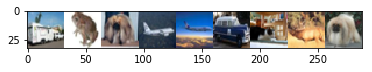

tensor([9.2913e-01, 1.0831e-03, 3.0140e-02, 4.9449e-03, 1.5384e-03, 2.5141e-02,
        6.0025e-03, 3.1423e-04, 1.7035e-03], dtype=torch.float64)


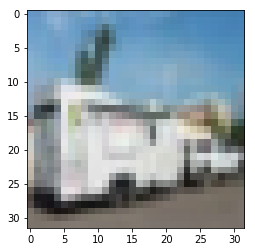

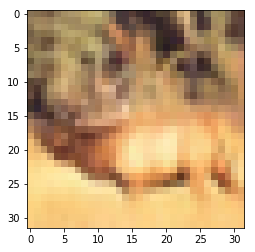

predicted truck
true truck
****************************************************************************************************


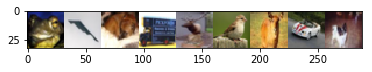

tensor([1.1143e-02, 3.6225e-05, 1.6310e-03, 9.4779e-01, 4.7903e-03, 1.4726e-03,
        6.3465e-04, 7.3990e-03, 2.5101e-02], dtype=torch.float64)


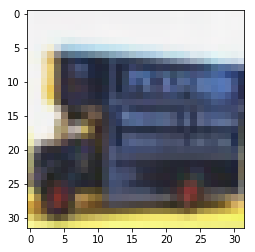

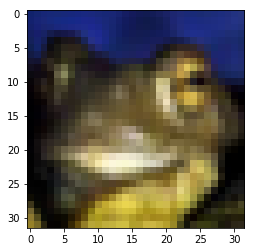

predicted truck
true truck
****************************************************************************************************


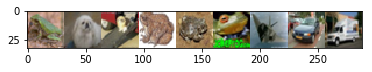

tensor([1.5130e-02, 2.7475e-02, 4.2396e-03, 1.4927e-03, 1.7342e-03, 5.2267e-04,
        5.1418e-02, 1.1700e-02, 8.8629e-01], dtype=torch.float64)


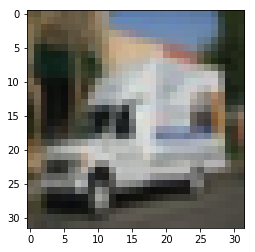

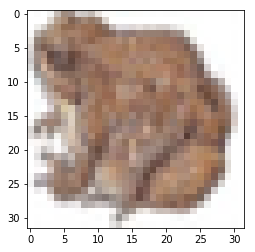

predicted truck
true truck
****************************************************************************************************


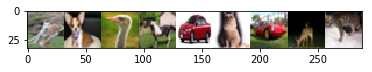

tensor([6.6324e-03, 2.1224e-03, 1.8668e-04, 9.2300e-01, 5.8428e-04, 1.0007e-02,
        2.9698e-02, 8.1600e-04, 2.6954e-02], dtype=torch.float64)


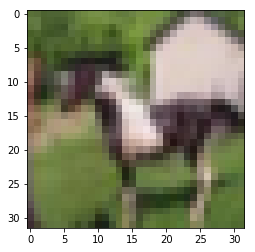

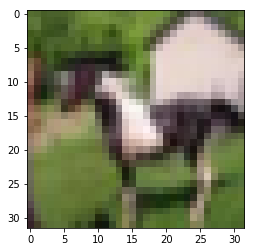

predicted horse
true horse
****************************************************************************************************


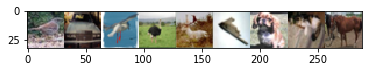

tensor([2.4165e-03, 1.4436e-02, 2.2959e-04, 4.9231e-04, 1.1214e-02, 9.8167e-05,
        1.2339e-03, 3.1008e-03, 9.6678e-01], dtype=torch.float64)


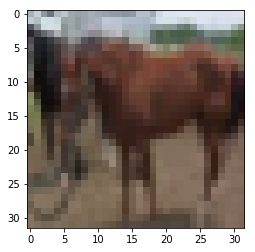

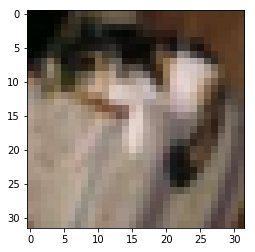

predicted horse
true horse
****************************************************************************************************


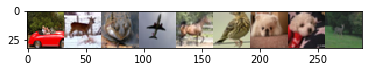

tensor([1.9950e-02, 6.4956e-02, 1.3443e-02, 4.3711e-02, 8.2921e-01, 8.9761e-03,
        1.2654e-03, 7.9426e-04, 1.7691e-02], dtype=torch.float64)


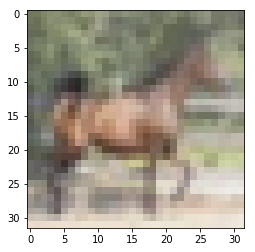

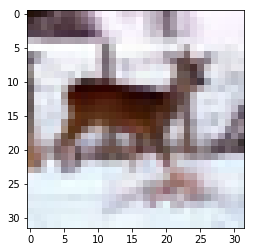

predicted horse
true horse
****************************************************************************************************


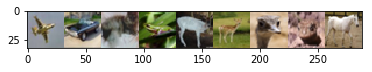

tensor([5.8492e-03, 3.6116e-03, 2.1426e-02, 4.6166e-04, 5.1975e-03, 7.9526e-04,
        1.2271e-03, 1.6681e-02, 9.4475e-01], dtype=torch.float64)


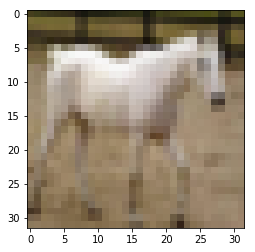

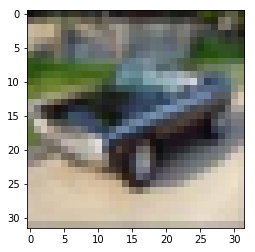

predicted horse
true horse
****************************************************************************************************


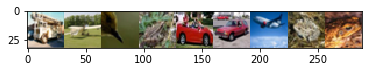

tensor([9.8939e-01, 2.4413e-03, 3.1703e-04, 2.5995e-03, 2.7788e-03, 4.4248e-04,
        1.4941e-03, 2.0924e-05, 5.1890e-04], dtype=torch.float64)


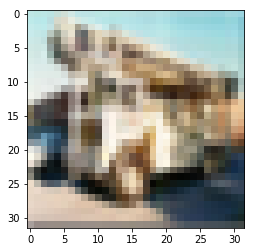

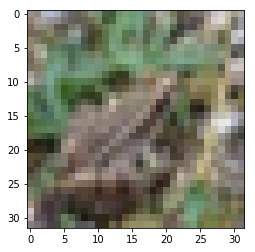

predicted truck
true truck
****************************************************************************************************


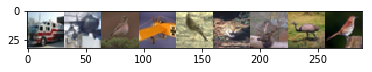

tensor([8.6921e-01, 1.6568e-02, 4.8735e-03, 7.5279e-02, 1.5365e-03, 2.2140e-02,
        9.8086e-03, 5.4926e-04, 3.0796e-05], dtype=torch.float64)


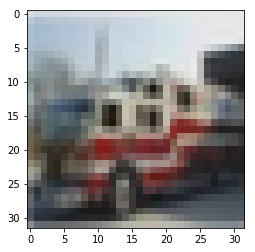

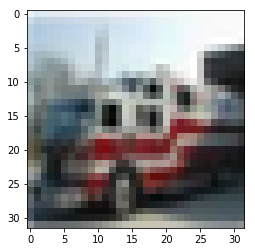

predicted truck
true truck
****************************************************************************************************


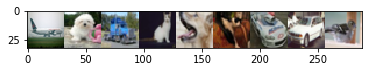

tensor([0.3851, 0.0031, 0.1339, 0.0085, 0.0145, 0.2435, 0.1113, 0.0553, 0.0449],
       dtype=torch.float64)


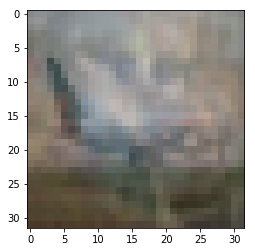

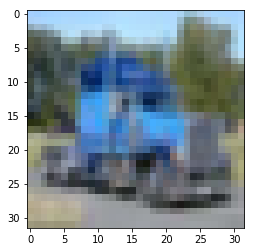

predicted truck
true truck
****************************************************************************************************


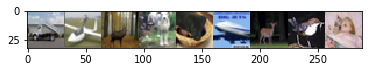

tensor([0.9076, 0.0398, 0.0088, 0.0104, 0.0138, 0.0055, 0.0029, 0.0013, 0.0098],
       dtype=torch.float64)


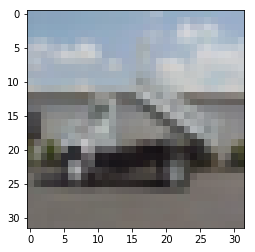

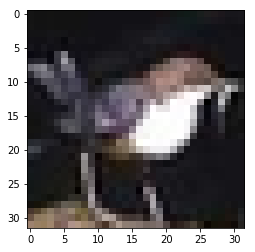

predicted truck
true truck
****************************************************************************************************


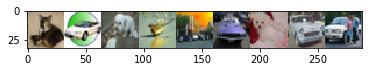

tensor([1.6156e-02, 6.7247e-05, 2.1377e-02, 2.8710e-04, 9.3341e-01, 8.8186e-03,
        4.4421e-03, 1.2252e-02, 3.1915e-03], dtype=torch.float64)


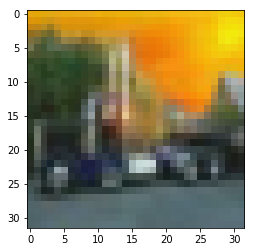

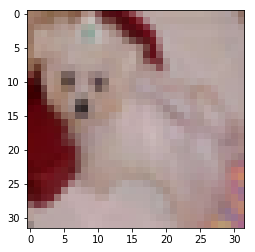

predicted truck
true truck
****************************************************************************************************


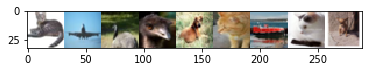

tensor([1.5359e-02, 1.5161e-03, 6.8266e-03, 4.6087e-03, 4.7940e-04, 1.1349e-03,
        9.4893e-01, 1.3304e-02, 7.8404e-03], dtype=torch.float64)


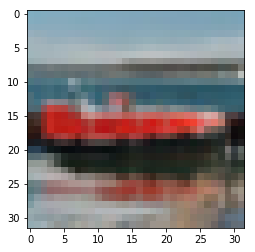

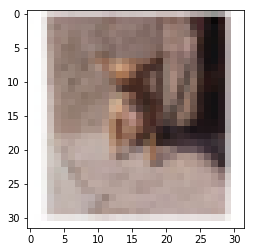

predicted ship
true ship
****************************************************************************************************


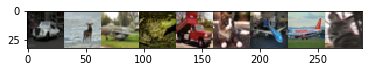

tensor([0.0304, 0.0317, 0.2522, 0.0145, 0.3164, 0.2345, 0.0296, 0.0696, 0.0210],
       dtype=torch.float64)


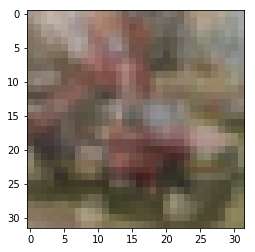

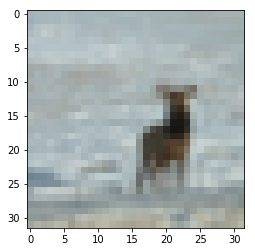

predicted truck
true truck
****************************************************************************************************


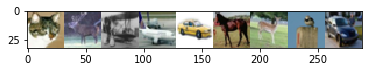

tensor([1.9311e-05, 3.7180e-05, 1.0064e-02, 2.3386e-04, 2.7692e-04, 9.8818e-01,
        8.0592e-05, 7.6186e-05, 1.0293e-03], dtype=torch.float64)


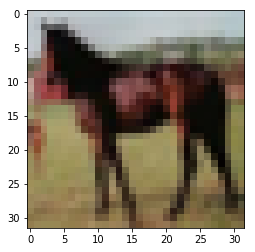

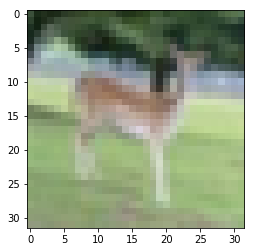

predicted horse
true horse
****************************************************************************************************


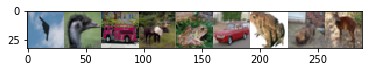

tensor([0.0059, 0.1035, 0.5603, 0.0010, 0.0157, 0.0300, 0.0242, 0.1654, 0.0940],
       dtype=torch.float64)


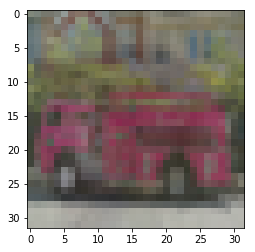

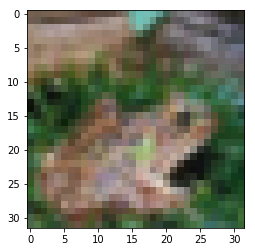

predicted truck
true truck
****************************************************************************************************


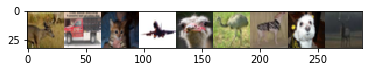

tensor([2.4824e-02, 8.7164e-01, 3.6052e-02, 1.3948e-04, 2.2009e-02, 1.8666e-03,
        5.5295e-03, 1.6494e-04, 3.7777e-02], dtype=torch.float64)


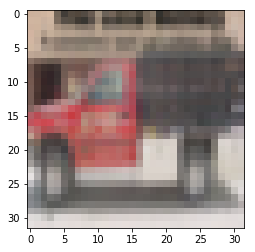

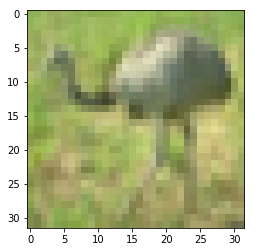

predicted truck
true truck
****************************************************************************************************


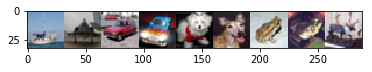

tensor([0.8738, 0.0389, 0.0026, 0.0326, 0.0027, 0.0027, 0.0009, 0.0043, 0.0415],
       dtype=torch.float64)


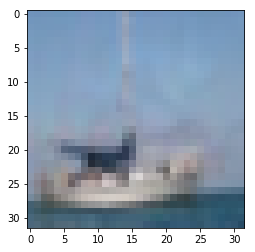

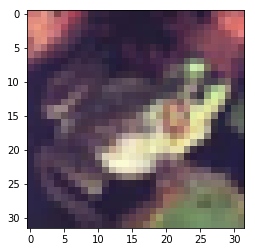

predicted ship
true ship
****************************************************************************************************


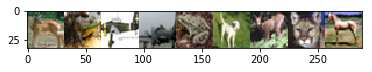

tensor([5.2341e-04, 5.8917e-04, 1.8425e-04, 3.6884e-02, 1.0523e-04, 1.4428e-04,
        4.0220e-03, 1.3263e-03, 9.5622e-01], dtype=torch.float64)


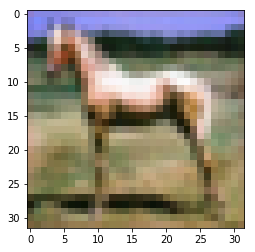

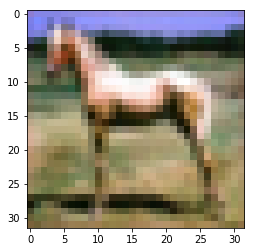

predicted horse
true horse
****************************************************************************************************


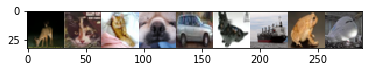

tensor([7.9247e-05, 7.4821e-04, 5.6911e-03, 2.8279e-03, 3.1989e-04, 6.9142e-04,
        9.8877e-01, 5.9623e-05, 8.1421e-04], dtype=torch.float64)


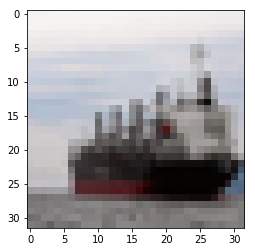

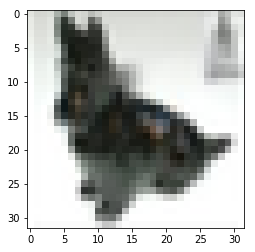

predicted ship
true ship
****************************************************************************************************


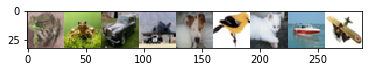

tensor([1.4136e-03, 3.3283e-05, 1.6393e-03, 8.9322e-04, 1.8225e-04, 6.1828e-06,
        2.5197e-05, 9.9578e-01, 2.4224e-05], dtype=torch.float64)


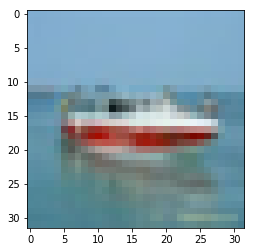

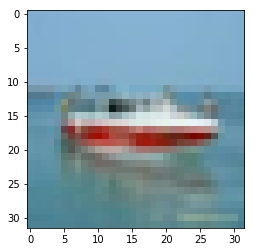

predicted ship
true ship
****************************************************************************************************


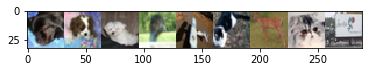

tensor([3.1520e-05, 7.9390e-05, 9.8641e-04, 1.2309e-04, 5.3868e-04, 1.3653e-03,
        1.0972e-03, 1.9038e-04, 9.9559e-01], dtype=torch.float64)


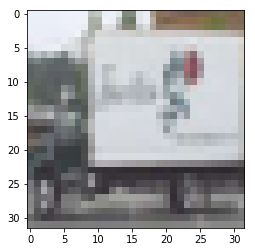

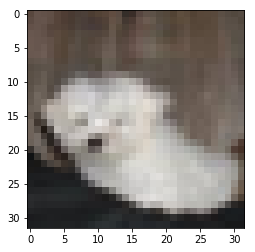

predicted truck
true truck
****************************************************************************************************


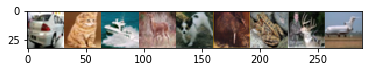

tensor([6.4185e-01, 1.6976e-04, 2.1206e-01, 5.2950e-02, 1.6139e-02, 2.1847e-02,
        6.5855e-03, 2.5087e-02, 2.3311e-02], dtype=torch.float64)


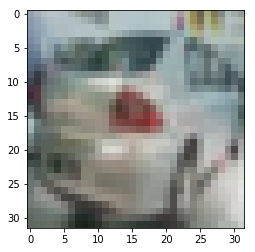

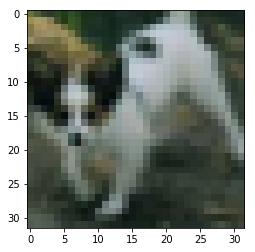

predicted ship
true ship
****************************************************************************************************


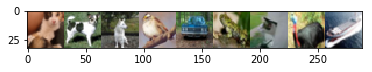

tensor([8.3028e-05, 6.1072e-03, 4.1084e-04, 2.5992e-03, 4.9780e-03, 4.8623e-05,
        4.9847e-04, 4.3528e-04, 9.8484e-01], dtype=torch.float64)


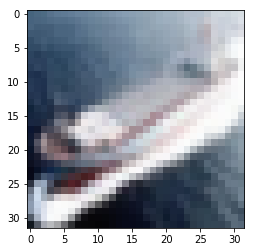

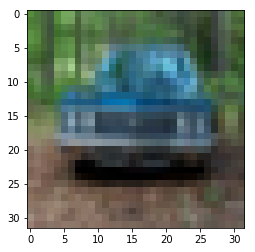

predicted ship
true ship
****************************************************************************************************


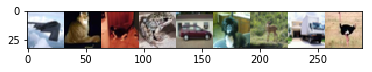

tensor([3.1830e-04, 9.9431e-05, 4.4769e-03, 5.4064e-04, 3.1028e-03, 7.2266e-03,
        2.6396e-03, 9.8153e-01, 6.2666e-05], dtype=torch.float64)


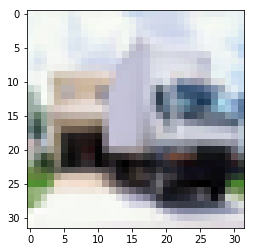

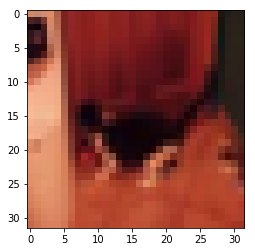

predicted truck
true truck
****************************************************************************************************


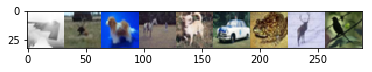

tensor([9.0149e-02, 5.1882e-01, 3.1146e-06, 5.8341e-02, 3.4234e-02, 1.0899e-01,
        1.4333e-01, 2.6297e-02, 1.9830e-02], dtype=torch.float64)


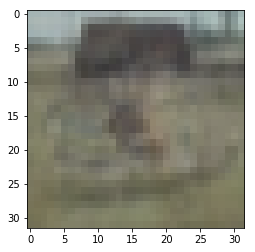

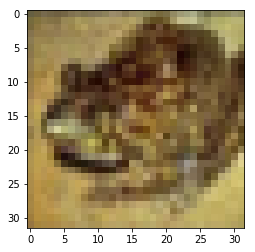

predicted horse
true horse
****************************************************************************************************


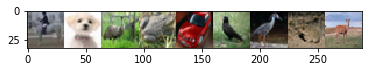

tensor([0.7969, 0.0227, 0.0447, 0.0040, 0.0429, 0.0132, 0.0107, 0.0116, 0.0533],
       dtype=torch.float64)


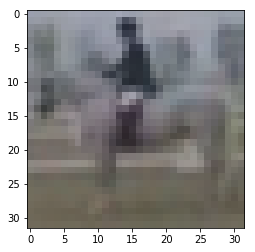

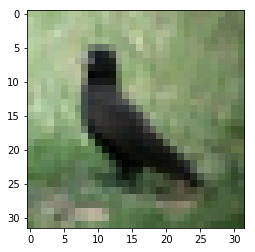

predicted horse
true horse
****************************************************************************************************


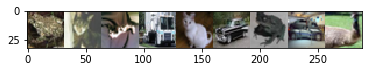

tensor([2.2135e-04, 2.0520e-04, 9.8256e-05, 9.8883e-01, 5.7599e-04, 4.3914e-04,
        5.3562e-04, 9.0915e-03, 4.6883e-06], dtype=torch.float64)


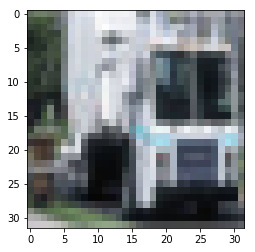

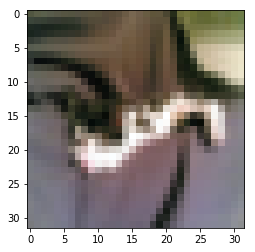

predicted truck
true truck
****************************************************************************************************


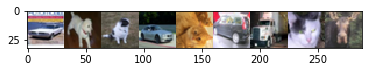

tensor([1.3563e-03, 3.1445e-05, 1.1732e-02, 8.2375e-04, 2.6819e-04, 1.3669e-02,
        9.6441e-01, 5.6689e-03, 2.0406e-03], dtype=torch.float64)


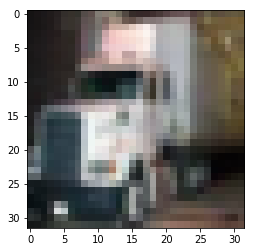

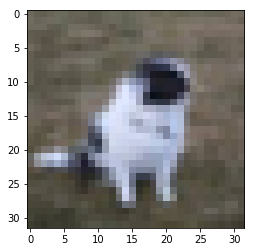

predicted truck
true truck
****************************************************************************************************


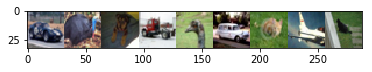

tensor([3.5471e-04, 2.6662e-03, 2.3233e-03, 3.8325e-01, 5.1324e-04, 1.6078e-03,
        3.0689e-04, 6.0831e-01, 6.6914e-04], dtype=torch.float64)


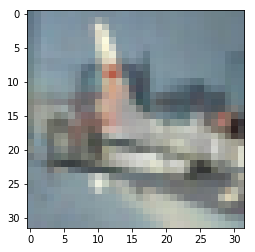

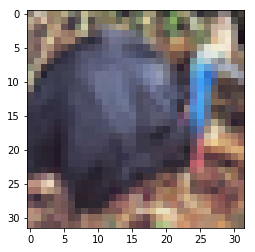

predicted ship
true truck
****************************************************************************************************


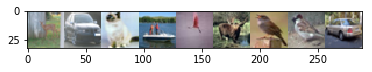

tensor([1.4158e-04, 8.7713e-05, 1.1197e-04, 9.9847e-01, 1.6800e-04, 7.1128e-04,
        3.9111e-06, 2.2139e-04, 8.8101e-05], dtype=torch.float64)


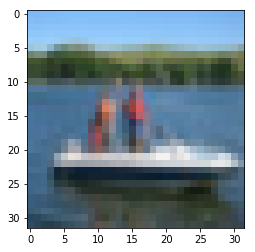

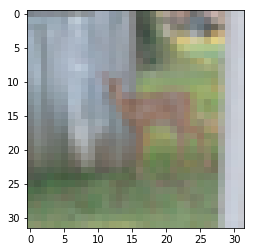

predicted ship
true ship
****************************************************************************************************


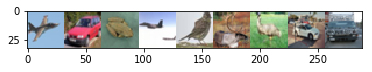

tensor([3.3359e-03, 1.1085e-04, 6.6110e-02, 5.2496e-03, 2.5920e-03, 8.7254e-03,
        9.2808e-03, 8.4835e-03, 8.9611e-01], dtype=torch.float64)


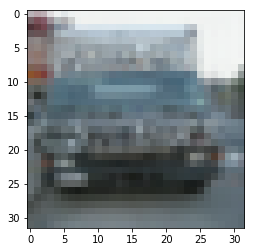

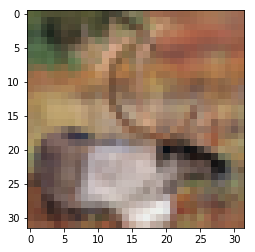

predicted truck
true truck
****************************************************************************************************


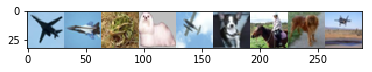

tensor([0.0007, 0.0169, 0.0423, 0.3066, 0.0018, 0.0217, 0.0986, 0.2249, 0.2865],
       dtype=torch.float64)


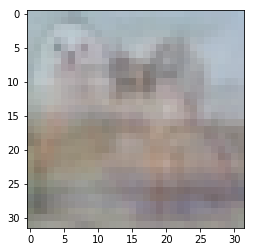

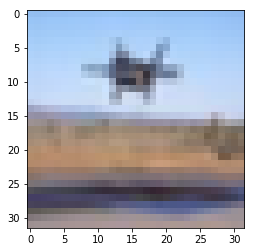

predicted horse
true horse
****************************************************************************************************


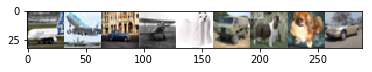

tensor([0.0010, 0.0036, 0.0888, 0.2299, 0.0306, 0.6015, 0.0270, 0.0007, 0.0168],
       dtype=torch.float64)


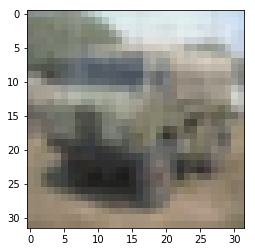

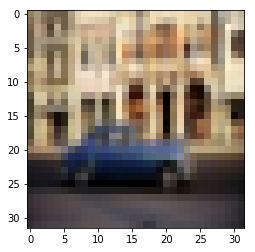

predicted truck
true truck
****************************************************************************************************


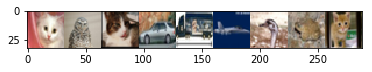

tensor([2.1155e-02, 3.9590e-02, 3.1052e-03, 2.5632e-02, 8.0704e-01, 4.4970e-02,
        4.3073e-02, 1.5082e-02, 3.5550e-04], dtype=torch.float64)


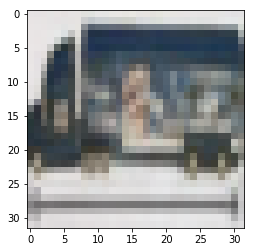

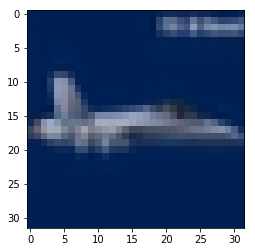

predicted truck
true truck
****************************************************************************************************


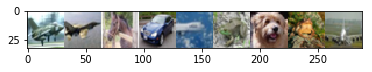

tensor([0.0178, 0.1666, 0.0331, 0.0200, 0.4624, 0.0745, 0.0029, 0.0041, 0.2186],
       dtype=torch.float64)


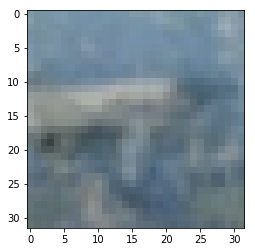

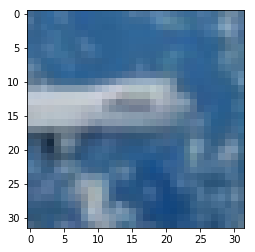

predicted horse
true horse
****************************************************************************************************


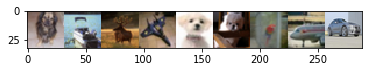

tensor([0.0112, 0.3027, 0.0278, 0.0506, 0.0228, 0.1174, 0.0949, 0.3101, 0.0625],
       dtype=torch.float64)


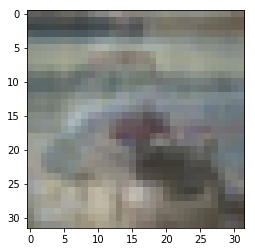

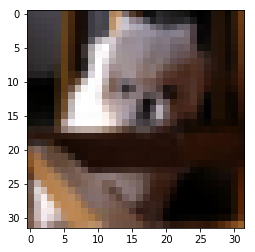

predicted ship
true ship
****************************************************************************************************


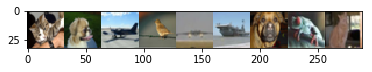

tensor([0.0519, 0.0012, 0.0041, 0.0202, 0.0961, 0.6037, 0.0036, 0.0898, 0.1293],
       dtype=torch.float64)


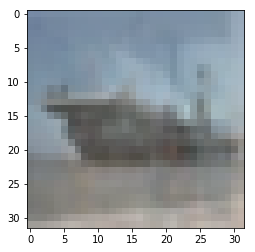

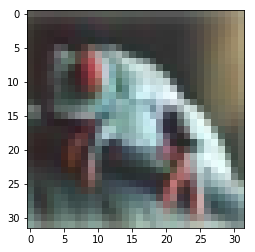

predicted ship
true ship
****************************************************************************************************


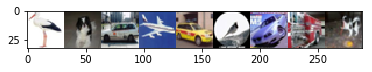

tensor([0.0152, 0.0177, 0.0748, 0.0091, 0.0021, 0.4281, 0.0014, 0.4486, 0.0030],
       dtype=torch.float64)


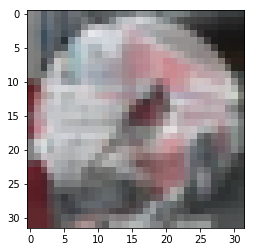

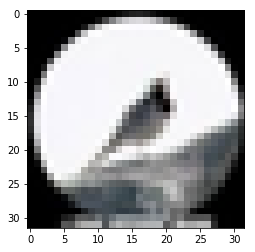

predicted truck
true truck
****************************************************************************************************


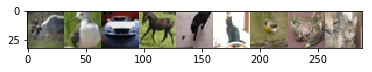

tensor([0.0018, 0.0011, 0.0633, 0.7627, 0.1536, 0.0015, 0.0039, 0.0089, 0.0031],
       dtype=torch.float64)


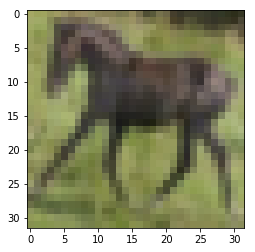

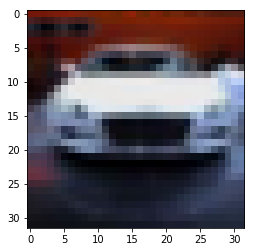

predicted horse
true horse
****************************************************************************************************


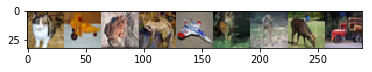

tensor([0.4013, 0.0129, 0.0286, 0.1581, 0.0584, 0.0078, 0.1235, 0.0398, 0.1697],
       dtype=torch.float64)


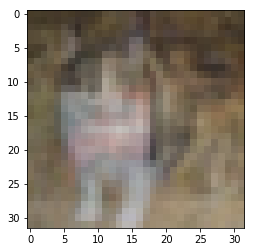

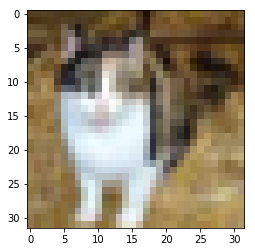

predicted horse
true truck
****************************************************************************************************


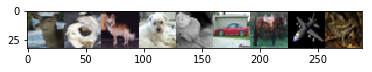

tensor([0.4179, 0.0493, 0.0109, 0.0425, 0.2489, 0.0298, 0.0921, 0.0815, 0.0272],
       dtype=torch.float64)


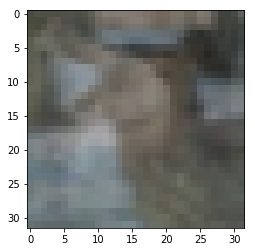

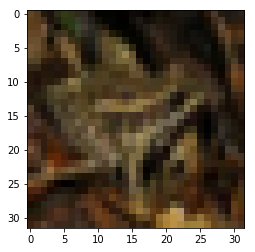

predicted horse
true horse
Accuracy of the network on the 10000 test images: 84 %
total correct 8487
total test set images 10000


In [111]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1)

        print(alphas[j])

        img2 = avg_images[j]
        display(img2)

        img3 = inputs[j][fore_idx_test[j]]
        display(img3)

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [36]:
print(torch.argmax(a) == 7)
print(batch)

tensor(1, dtype=torch.uint8)
250


In [112]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 98 %
total correct 29469
total train set images 30000
focus_true_pred_true 25252
focus_false_pred_true 4217
focus_true_pred_false 151
focus_false_pred_false 380
argmax_more_than_half 25656
argmax_less_than_half 4344


In [114]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 84 %
total correct 8487
total train set images 10000
focus_true_pred_true 7473
focus_false_pred_true 1014
focus_true_pred_false 423
focus_false_pred_false 1090
argmax_more_than_half 7999
argmax_less_than_half 2001
